### Q3. What groups are best optimizing their memory usage in terms of percent of actual memory used of the memory requested for a job? What is the average percent for each group?
* Name the dataframe ``accre_mem_use``
* Filter out rows with ``EXITCODE`` values that are not '0:0' (success)
* for a)
    * Sum 6-month totals for each user group
    * Get an average for the group by summing their total requested and total utilized memory
    * Visualize this across the groups (which ones are doing well, which ones are not doing as well)

* for b)
    * Group the dataframe by the user groups
    * Create a new column denoting each job's percent utilization
    * Get a median % for the group
    * Visualize the range and std deviation and/or IQR and median for the top and bottom performers


In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
accre_mem_use = pd.read_csv('../data/accre_cleaned_no_nodelist.csv')
accre_mem_use.head()

,Unnamed: 0,JOBID,ACCOUNT,USER,REQMEM,REQMEM_PER_CORE,USEDMEM,USEDMEM_PER_CORE_01,USEDMEM_PER_CORE_02,REQTIME,REQTIME_SEC,USEDTIME,USEDTIME_SEC,NODES,CPUS,PARTITION,EXITCODE,STATE
0,0,15925210,treviso,arabella,122880Mn,5120.0,65973.49M,2748.875000,2748.875000,13-18:00:00,1188000.0,13-18:00:28,1188028.0,1,24,production,0:0,COMPLETED
1,1,15861126,treviso,arabella,122880Mn,5120.0,67181.12M,2799.208333,2799.208333,13-18:00:00,1188000.0,12-14:50:56,1090256.0,1,24,production,0:0,COMPLETED
2,2,15861125,treviso,arabella,122880Mn,5120.0,69111.86M,2879.625000,2879.625000,13-18:00:00,1188000.0,13-18:00:20,1188020.0,1,24,production,0:0,COMPLETED
3,3,16251645,treviso,arabella,122880Mn,5120.0,65317.33M,2721.541667,2721.541667,13-18:00:00,1188000.0,12-03:50:32,1050632.0,1,24,production,0:0,COMPLETED
4,4,16251646,treviso,arabella,122880Mn,5120.0,65876.11M,2744.833333,2744.833333,13-18:00:00,1188000.0,13-18:00:03,1188003.0,1,24,production,0:0,COMPLETED


In [4]:
accre_mem_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816290 entries, 0 to 3816289
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   JOBID                object 
 2   ACCOUNT              object 
 3   USER                 object 
 4   REQMEM               object 
 5   REQMEM_PER_CORE      float64
 6   USEDMEM              object 
 7   USEDMEM_PER_CORE_01  float64
 8   USEDMEM_PER_CORE_02  float64
 9   REQTIME              object 
 10  REQTIME_SEC          float64
 11  USEDTIME             object 
 12  USEDTIME_SEC         float64
 13  NODES                int64  
 14  CPUS                 int64  
 15  PARTITION            object 
 16  EXITCODE             object 
 17  STATE                object 
dtypes: float64(5), int64(3), object(10)
memory usage: 524.1+ MB


In [5]:
# Check for unique failure codes and how many results are non-0:0
print(accre_mem_use['EXITCODE'].value_counts())
# 99.9% of jobs have a 0:0 EXITCODE value

0:0      3813403
1:0         1155
0:9          838
0:15         354
127:0        143
2:0          135
0:125         95
7:0           48
0:7           15
6:0           15
126:0         11
13:0          11
0:11          11
38:0           9
24:0           7
11:0           6
0:39           5
59:0           4
0:6            4
116:0          4
0:12           3
99:0           2
8:0            2
0:2            2
64:0           2
0:105          2
0:4            1
101:0          1
0:36           1
16:0           1
Name: EXITCODE, dtype: int64


In [6]:
# Check for unique STATES and determine the % of COMPLETED
print(accre_mem_use.STATE.value_counts())
# 99.7% of jobs are in the 'COMPLETED' STATE

COMPLETED              3804644
CANCELLED                 6107
RUNNING                   3108
FAILED                    1406
CANCELLED by 686562        681
OUT_OF_MEMORY               94
TIMEOUT                     80
CANCELLED by 505355         63
CANCELLED by 855431         17
CANCELLED by 782611         13
CANCELLED by 9206            9
CANCELLED by 397600          7
CANCELLED by 200557          6
CANCELLED by 0               5
CANCELLED by 199766          4
CANCELLED by 486541          4
CANCELLED by 454080          4
CANCELLED by 9202            3
CANCELLED by 9201            3
CANCELLED by 649319          3
CANCELLED by 483348          3
CANCELLED by 515423          2
CANCELLED by 546080          2
CANCELLED by 124006          2
CANCELLED by 791651          2
CANCELLED by 895426          2
CANCELLED by 90423           2
CANCELLED by 666860          2
CANCELLED by 199066          2
CANCELLED by 693461          2
CANCELLED by 651701          1
CANCELLED by 781109          1
CANCELLE

In [7]:
# Check the unique partitions and their associated value_counts
accre_mem_use['PARTITION'].value_counts()

production              3311788
nogpfs                   327652
sam                       79151
pascal                    48004
turing                    39406
debug                      6738
maxwell                    3348
cgw-capra1                   83
cgw-dougherty1               72
cgw-cqs1                     34
cgw-cqs3                      4
cgw-vm-qa-flatearth1          4
cgw-rocksteady                2
cgw-tbi01                     2
devel                         2
Name: PARTITION, dtype: int64

In [8]:
# Check to see if CMS is the only account using the nogpfs partition:
accre_mem_use[(accre_mem_use['PARTITION'] == 'nogpfs')]['ACCOUNT'].value_counts()

cms         310617
grisette     11017
sharlin       5935
tosca           83
Name: ACCOUNT, dtype: int64

In [9]:
# Check to see what other partitions the three non-CMS accounts who use the nogpfs partition use
non_cms_nogpfs_accounts = ['grisette', 'sharlin', 'tosca']
accre_mem_use[(accre_mem_use['ACCOUNT'].isin(non_cms_nogpfs_accounts))]['PARTITION'].value_counts()

production    82965
nogpfs        17035
debug             7
devel             2
Name: PARTITION, dtype: int64

These three users ('grisette', 'sharlin', and 'tosca') represent c. 2.5% of the successful jobs run on production and c. 4.9% of the successful jobs run on the nogpfs partition.  
In addition, for these three users, nogpfs jobs account for 17.2% of their jobs.  
Given the small percentage of jobs that these users represent overall (on both the production and nogpfs partitions), and in conjunction with Eric's statement that the 'nogpfs' partition is of interest only to CMS, the 'nogpfs' partition will be dropped for the non-CMS and GPU analysis, though I am curious who these three accounts are that are still leveraging the older nodes for their work.

In [10]:
print(accre_mem_use.USEDMEM.value_counts())

0            602577
0.09M         78240
0.79M         54176
6.23M         52699
6.24M         45150
              ...  
4606.04M          1
17206.32M         1
11411.15M         1
7169.12M          1
74202.50M         1
Name: USEDMEM, Length: 836096, dtype: int64


In [11]:
# Calculate the total requested memory for each job:
accre_mem_use['REQMEM_TOT'] = accre_mem_use['REQMEM_PER_CORE']*accre_mem_use['CPUS']
# Calculate the total used memory for each job, assuming that USEDMEM is the maximum per node in multi-node jobs:
accre_mem_use['USEDMEM_TOT_01'] = accre_mem_use['USEDMEM_PER_CORE_01']*accre_mem_use['CPUS']
# Calculate the total used memory for each job, assuming that USEDMEM is the maximum per job in multi-node jobs:
accre_mem_use['USEDMEM_TOT_02'] = accre_mem_use['USEDMEM_PER_CORE_02']*accre_mem_use['CPUS']

In [12]:
# Calculate the used-to-requested memory ratio for each job, assuming that USEDMEM is the maximum per node:
accre_mem_use['USEDMEM_PCT_JOB_01'] = accre_mem_use['USEDMEM_TOT_01'] / accre_mem_use['REQMEM_TOT']
# Calculate the used-to-requested memory ratio for each job, assuming that USEDMEM is the maximum per job:
accre_mem_use['USEDMEM_PCT_JOB_02'] = accre_mem_use['USEDMEM_TOT_02'] / accre_mem_use['REQMEM_TOT']
# These set us up, if we want, to look at the median per group

In [13]:
# To filter out partitions that are not of general interest:
all_par = ['debug', 'maxwell', 'nogpfs', 'pascal', 'turing']
# To filter to only GPU partitions:
gpu_par = ['debug', 'maxwell', 'pascal', 'turing']
# To only filter out the debug partition:
debug_par = ['debug']
# Change the variable passed to isin() as needed:
accre_mem_use = accre_mem_use[~accre_mem_use['PARTITION'].isin(all_par)]

In [14]:
# To filter out all CMS accounts, start with this list:
cms = ['cms', 'cms_gpu_acc', 'cms_lowprio', 'cmsadmin']
# Then create a CMS-free dataframe:
accre_mem_no_cms = accre_mem_use[~accre_mem_use['ACCOUNT'].isin(cms)]
# And a CMS-only dataframe:
# REMEMBER TO ALSO CHANGE THE PARTITIONS IN THE CELL ABOVE BEFORE USING
accre_mem_cms_only = accre_mem_use[accre_mem_use['ACCOUNT'].isin(cms)]
# Check to make sure CMS is removed from the Accounts in the new dataframe:
print(accre_mem_no_cms.ACCOUNT.sort_values().unique())
# And that the CMS-only one looks right, too:
print(accre_mem_cms_only.ACCOUNT.sort_values().unique())

['alkmene' 'almonds' 'amaranth' 'angelys' 'anise' 'antares' 'arra'
 'atemoyas' 'baby' 'baking' 'bay' 'bell' 'belle' 'bertanne' 'bibb'
 'blackberries' 'bon' 'boysenberries' 'brazilnuts' 'broccoli' 'bulk'
 'bunch' 'burro' 'cactus' 'cantared' 'carambola' 'carrot' 'casaba'
 'celery' 'cep' 'chasselas' 'chayote' 'chickpeas' 'chipilin' 'cinnabar'
 'clara' 'cocktail' 'concord' 'conference' 'crab' 'crowns' 'delblush'
 'dill' 'discovery' 'emmons' 'fairchild' 'fava' 'fiddlehead' 'flamingo'
 'florence' 'forelle' 'francis' 'fresh' 'galangal' 'galia' 'garlic' 'gobo'
 'golden' 'grisette' 'harovin' 'hass' 'hearts' 'horn' 'horseradish'
 'huaguan' 'ingrid' 'jicama' 'josephine' 'kabocha' 'key' 'kinnow'
 'kumquat' 'large' 'leaves' 'lemon' 'lochbuie' 'lollo' 'long' 'lychees'
 'mache' 'malanga' 'mangosteen' 'medium' 'mickey' 'mignonette' 'milwa'
 'minnewashta' 'mixed' 'mung' 'muscat' 'nino' 'orange' 'oroblanco'
 'pasilla' 'peanuts' 'pearl' 'pecans' 'pepino' 'pickling' 'pink' 'pinova'
 'pioppino' 'pitted' 'p

In [15]:
accre_mem_no_cms.drop('Unnamed: 0', axis=1)

,JOBID,ACCOUNT,USER,REQMEM,REQMEM_PER_CORE,USEDMEM,USEDMEM_PER_CORE_01,USEDMEM_PER_CORE_02,REQTIME,REQTIME_SEC,USEDTIME,USEDTIME_SEC,NODES,CPUS,PARTITION,EXITCODE,STATE,REQMEM_TOT,USEDMEM_TOT_01,USEDMEM_TOT_02,USEDMEM_PCT_JOB_01,USEDMEM_PCT_JOB_02
0,15925210,treviso,arabella,122880Mn,5120.0,65973.49M,2748.875000,2748.875000,13-18:00:00,1188000.0,13-18:00:28,1188028.0,1,24,production,0:0,COMPLETED,122880.0,65973.0,65973.0,0.536890,0.536890
1,15861126,treviso,arabella,122880Mn,5120.0,67181.12M,2799.208333,2799.208333,13-18:00:00,1188000.0,12-14:50:56,1090256.0,1,24,production,0:0,COMPLETED,122880.0,67181.0,67181.0,0.546720,0.546720
2,15861125,treviso,arabella,122880Mn,5120.0,69111.86M,2879.625000,2879.625000,13-18:00:00,1188000.0,13-18:00:20,1188020.0,1,24,production,0:0,COMPLETED,122880.0,69111.0,69111.0,0.562427,0.562427
3,16251645,treviso,arabella,122880Mn,5120.0,65317.33M,2721.541667,2721.541667,13-18:00:00,1188000.0,12-03:50:32,1050632.0,1,24,production,0:0,COMPLETED,122880.0,65317.0,65317.0,0.531551,0.531551
4,16251646,treviso,arabella,122880Mn,5120.0,65876.11M,2744.833333,2744.833333,13-18:00:00,1188000.0,13-18:00:03,1188003.0,1,24,production,0:0,COMPLETED,122880.0,65876.0,65876.0,0.536100,0.536100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816285,24173815_8,portabella,vennie,32768Mn,16384.0,30042.68M,15021.000000,15021.000000,1-00:00:00,86400.0,00:02:27,147.0,1,2,production,0:0,COMPLETED,32768.0,30042.0,30042.0,0.916809,0.916809
3816286,24173815_9,portabella,vennie,32768Mn,16384.0,31067.75M,15533.500000,15533.500000,1-00:00:00,86400.0,00:02:27,147.0,1,2,production,0:0,COMPLETED,32768.0,31067.0,31067.0,0.948090,0.948090
3816287,24173815_10,portabella,vennie,32768Mn,16384.0,21207.96M,10603.500000,10603.500000,1-00:00:00,86400.0,00:01:40,100.0,1,2,production,0:0,COMPLETED,32768.0,21207.0,21207.0,0.647186,0.647186
3816288,24173817,boysenberries,hortensia,100000Mn,12500.0,0,0.000000,0.000000,1-00:00:00,86400.0,00:03:05,185.0,1,8,production,0:0,RUNNING,100000.0,0.0,0.0,0.000000,0.000000


In [16]:
# Only get successful jobs (EXITCODE = 0:0) that are completed (STATE = 'COMPLETED'), on the production PARTITION, and where USEDMEM != 0
accre_mem_use = accre_mem_use[(accre_mem_use['EXITCODE'] == '0:0') & (accre_mem_use['STATE'] == 'COMPLETED') & (accre_mem_use['PARTITION'] == 'production') & (accre_mem_use['USEDMEM'] != 0)]
# Rerun the previous cells to make sure everything is successful and completed

In [17]:
# Quick cleanup
accre_mem_use = accre_mem_use.drop('Unnamed: 0', axis = 1)

In [65]:
accre_mem_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3302522 entries, 0 to 3816287
Data columns (total 22 columns):
 #   Column               Dtype  
---  ------               -----  
 0   JOBID                object 
 1   ACCOUNT              object 
 2   USER                 object 
 3   REQMEM               object 
 4   REQMEM_PER_CORE      float64
 5   USEDMEM              object 
 6   USEDMEM_PER_CORE_01  float64
 7   USEDMEM_PER_CORE_02  float64
 8   REQTIME              object 
 9   REQTIME_SEC          float64
 10  USEDTIME             object 
 11  USEDTIME_SEC         float64
 12  NODES                int64  
 13  CPUS                 int64  
 14  PARTITION            object 
 15  EXITCODE             object 
 16  STATE                object 
 17  REQMEM_TOT           float64
 18  USEDMEM_TOT_01       float64
 19  USEDMEM_TOT_02       float64
 20  USEDMEM_PCT_JOB_01   float64
 21  USEDMEM_PCT_JOB_02   float64
dtypes: float64(10), int64(2), object(10)
memory usage: 579.5+ MB


In [66]:
accre_mem_use.describe()

,REQMEM_PER_CORE,USEDMEM_PER_CORE_01,USEDMEM_PER_CORE_02,REQTIME_SEC,USEDTIME_SEC,NODES,CPUS,REQMEM_TOT,USEDMEM_TOT_01,USEDMEM_TOT_02,USEDMEM_PCT_JOB_01,USEDMEM_PCT_JOB_02
count,3.302522e+06,3302522.0,3302522.0,3.302522e+06,3.302522e+06,3.302522e+06,3.302522e+06,3.302522e+06,3.302508e+06,3.302508e+06,3.302508e+06,3.302508e+06
mean,8.001304e+03,inf,inf,1.091010e+05,1.512790e+04,1.012653e+00,1.928585e+00,1.547447e+04,3.211220e+03,3.197565e+03,2.334666e-01,2.326339e-01
std,6.265857e+03,NaN,NaN,1.434605e+05,4.449794e+04,9.988454e-01,2.058537e+00,2.215530e+04,7.362117e+03,6.855471e+03,4.524362e-01,2.549598e-01
min,1.666667e-01,0.0,0.0,6.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.096000e+03,21.0,21.0,1.320000e+04,1.600000e+02,1.000000e+00,1.000000e+00,4.096000e+03,2.100000e+01,2.100000e+01,6.835938e-03,6.835938e-03
50%,7.000000e+03,588.0,588.0,6.480000e+04,1.691000e+03,1.000000e+00,1.000000e+00,8.192000e+03,6.360000e+02,6.360000e+02,1.135300e-01,1.135000e-01
75%,1.228800e+04,2110.0,2109.0,1.728000e+05,1.082500e+04,1.000000e+00,2.000000e+00,2.048000e+04,3.586000e+03,3.571000e+03,3.984375e-01,3.981120e-01
max,3.072000e+06,inf,inf,1.209600e+06,1.713865e+06,5.000000e+02,2.400000e+01,6.144000e+06,2.704737e+06,2.473980e+05,5.282689e+02,2.100000e+01


In [68]:
accre_mem_use.median()

JOBID                  1.892117e+09
REQMEM_PER_CORE        7.000000e+03
USEDMEM_PER_CORE_01    5.880000e+02
USEDMEM_PER_CORE_02    5.880000e+02
REQTIME_SEC            6.480000e+04
USEDTIME_SEC           1.691000e+03
NODES                  1.000000e+00
CPUS                   1.000000e+00
REQMEM_TOT             8.192000e+03
USEDMEM_TOT_01         6.360000e+02
USEDMEM_TOT_02         6.360000e+02
USEDMEM_PCT_JOB_01     1.135300e-01
USEDMEM_PCT_JOB_02     1.135000e-01
dtype: float64

**FROM HERE ON, USING THE VARIABLE ``mem`` TO SWITCH BETWEEN CMS-ONLY AND NO-CMS DATAFRAMES.**

In [19]:
mem = accre_mem_use.reset_index(drop=True)

In [20]:
# mem.drop('Unnamed: 0', axis=1)

In [21]:
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302522 entries, 0 to 3302521
Data columns (total 22 columns):
 #   Column               Dtype  
---  ------               -----  
 0   JOBID                object 
 1   ACCOUNT              object 
 2   USER                 object 
 3   REQMEM               object 
 4   REQMEM_PER_CORE      float64
 5   USEDMEM              object 
 6   USEDMEM_PER_CORE_01  float64
 7   USEDMEM_PER_CORE_02  float64
 8   REQTIME              object 
 9   REQTIME_SEC          float64
 10  USEDTIME             object 
 11  USEDTIME_SEC         float64
 12  NODES                int64  
 13  CPUS                 int64  
 14  PARTITION            object 
 15  EXITCODE             object 
 16  STATE                object 
 17  REQMEM_TOT           float64
 18  USEDMEM_TOT_01       float64
 19  USEDMEM_TOT_02       float64
 20  USEDMEM_PCT_JOB_01   float64
 21  USEDMEM_PCT_JOB_02   float64
dtypes: float64(10), int64(2), object(10)
memory usage: 554.3+ MB


In [22]:
mem.head()

,JOBID,ACCOUNT,USER,REQMEM,REQMEM_PER_CORE,USEDMEM,USEDMEM_PER_CORE_01,USEDMEM_PER_CORE_02,REQTIME,REQTIME_SEC,USEDTIME,USEDTIME_SEC,NODES,CPUS,PARTITION,EXITCODE,STATE,REQMEM_TOT,USEDMEM_TOT_01,USEDMEM_TOT_02,USEDMEM_PCT_JOB_01,USEDMEM_PCT_JOB_02
0,15925210,treviso,arabella,122880Mn,5120.0,65973.49M,2748.875000,2748.875000,13-18:00:00,1188000.0,13-18:00:28,1188028.0,1,24,production,0:0,COMPLETED,122880.0,65973.0,65973.0,0.536890,0.536890
1,15861126,treviso,arabella,122880Mn,5120.0,67181.12M,2799.208333,2799.208333,13-18:00:00,1188000.0,12-14:50:56,1090256.0,1,24,production,0:0,COMPLETED,122880.0,67181.0,67181.0,0.546720,0.546720
2,15861125,treviso,arabella,122880Mn,5120.0,69111.86M,2879.625000,2879.625000,13-18:00:00,1188000.0,13-18:00:20,1188020.0,1,24,production,0:0,COMPLETED,122880.0,69111.0,69111.0,0.562427,0.562427
3,16251645,treviso,arabella,122880Mn,5120.0,65317.33M,2721.541667,2721.541667,13-18:00:00,1188000.0,12-03:50:32,1050632.0,1,24,production,0:0,COMPLETED,122880.0,65317.0,65317.0,0.531551,0.531551
4,16251646,treviso,arabella,122880Mn,5120.0,65876.11M,2744.833333,2744.833333,13-18:00:00,1188000.0,13-18:00:03,1188003.0,1,24,production,0:0,COMPLETED,122880.0,65876.0,65876.0,0.536100,0.536100


The dataframe, without the CMS jobs; debug, nogpfs, and GPU partitions; and only successful and completed jobs has 2,655,086 unique JOBIDs remaining. This represents 69.6% of the JOBIDs shared with us by ACCRE.

In [23]:
# Create a new grouped dataframe with aggregate values
#accre_grouped_by_account = mem.groupby('ACCOUNT').agg(
#    {  USEDMEM_TOT_BY_GROUP_01='USEDMEM_TOT_01', sum),
#       USEDMEM_TOT_BY_GROUP_02 = ('USEDMEM_TOT_02', sum),
#       REQMEM_TOT_BY_GROUP = ('REQMEM_TOT', sum),
#       TOT_JOBS = ('JOB_ID', count),
#       REQMEM_RANGE = pd.NamedAgg(column='REQMEM_TOT', aggfunc=lambda x: (max(x) - min(x))),
#       USEDMEM_RANGE_01 = pd.NamedAgg(column='USEDMEM_TOT_01', aggfunc=lambda x: (max(x) - min(x))),
#       USEDMEM_RANGE_02 = pd.NamedAgg(column='USEDMEM_TOT_02', aggfunc=lambda x: (max(x) - min(x)))    
#    }
#)
#accre_grouped_by_account.head(200)

In [24]:
accre_grouped_by_account = mem.groupby('ACCOUNT').agg(
    {  'USEDMEM_TOT_01': 'sum',
        'USEDMEM_TOT_02': 'sum',
        'REQMEM_TOT': 'sum',
        'JOBID': 'count',
        'REQTIME_SEC': 'sum',
        'USEDTIME_SEC': 'sum',
         'NODES' : 'sum'
    }
)
accre_grouped_by_account.head(200)

,USEDMEM_TOT_01,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES
ACCOUNT,,,,,,,
alkmene,4.702052e+07,4.653672e+07,1.369190e+08,15593,7.720452e+07,3.558229e+07,15644
almonds,2.567816e+06,2.567816e+06,1.927117e+07,1887,2.857140e+07,1.745246e+06,1887
amaranth,7.313580e+05,7.313580e+05,2.484634e+07,3033,1.388969e+09,9.305510e+07,3033
angelys,1.076160e+05,2.495000e+03,9.574400e+05,897,7.134600e+05,4.551630e+05,30732
anise,1.045693e+07,1.045693e+07,5.097240e+07,1751,8.862600e+07,1.453794e+07,1751
antares,2.425510e+05,2.425510e+05,4.915200e+05,160,1.382400e+07,4.224500e+05,160
arra,5.142013e+06,1.366660e+06,1.072947e+07,65,2.312100e+06,6.218000e+05,365
atemoyas,1.713274e+07,1.713274e+07,2.668677e+08,25012,1.636805e+09,5.542806e+07,25012
baby,3.776754e+06,3.776754e+06,3.185000e+08,3185,2.370470e+09,1.421372e+07,3185


In [25]:
# Create a new column, USEDMEM_PCT, which contains the % of memory utilization grouped by each account:
accre_grouped_by_account['USEDMEM_PCT_01'] = (accre_grouped_by_account['USEDMEM_TOT_01'] / accre_grouped_by_account['REQMEM_TOT'])*100
# Create a new column, USEDMEM_PCT, which contains the % of memory utilization grouped by each account:
accre_grouped_by_account['USEDMEM_PCT_02'] = (accre_grouped_by_account['USEDMEM_TOT_02'] / accre_grouped_by_account['REQMEM_TOT'])*100

In [26]:
# Create a NODES_PER_JOB column to figure out which accounts would be most affected by the different usedmem calculations:
accre_grouped_by_account['NODES_PER_JOB'] = accre_grouped_by_account['NODES'] / accre_grouped_by_account['JOBID']
# Also create a diff column between the calculated used mem rates:
accre_grouped_by_account['USEDMEM_DIFF'] = accre_grouped_by_account['USEDMEM_PCT_01'] - accre_grouped_by_account['USEDMEM_PCT_02']

In [27]:
# Turn Account into a column
accre_grouped_by_account.reset_index(inplace=True)
# Check that it worked
accre_grouped_by_account.columns

Index(['ACCOUNT', 'USEDMEM_TOT_01', 'USEDMEM_TOT_02', 'REQMEM_TOT', 'JOBID', 'REQTIME_SEC', 'USEDTIME_SEC', 'NODES', 'USEDMEM_PCT_01', 'USEDMEM_PCT_02', 'NODES_PER_JOB', 'USEDMEM_DIFF'], dtype='object')

In [28]:
accre_grouped_by_account.head(200)

,ACCOUNT,USEDMEM_TOT_01,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_01,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF
0,alkmene,4.702052e+07,4.653672e+07,1.369190e+08,15593,7.720452e+07,3.558229e+07,15644,34.341857,33.988503,1.003271,0.353354
1,almonds,2.567816e+06,2.567816e+06,1.927117e+07,1887,2.857140e+07,1.745246e+06,1887,13.324652,13.324652,1.000000,0.000000
2,amaranth,7.313580e+05,7.313580e+05,2.484634e+07,3033,1.388969e+09,9.305510e+07,3033,2.943525,2.943525,1.000000,0.000000
3,angelys,1.076160e+05,2.495000e+03,9.574400e+05,897,7.134600e+05,4.551630e+05,30732,11.239973,0.260591,34.260870,10.979383
4,anise,1.045693e+07,1.045693e+07,5.097240e+07,1751,8.862600e+07,1.453794e+07,1751,20.514894,20.514894,1.000000,0.000000
5,antares,2.425510e+05,2.425510e+05,4.915200e+05,160,1.382400e+07,4.224500e+05,160,49.347127,49.347127,1.000000,0.000000
6,arra,5.142013e+06,1.366660e+06,1.072947e+07,65,2.312100e+06,6.218000e+05,365,47.924194,12.737439,5.615385,35.186755
7,atemoyas,1.713274e+07,1.713274e+07,2.668677e+08,25012,1.636805e+09,5.542806e+07,25012,6.419936,6.419936,1.000000,0.000000
8,baby,3.776754e+06,3.776754e+06,3.185000e+08,3185,2.370470e+09,1.421372e+07,3185,1.185794,1.185794,1.000000,0.000000
9,baking,1.553527e+07,1.553527e+07,5.774131e+07,491,1.001731e+08,5.309806e+07,491,26.904955,26.904955,1.000000,0.000000


In [29]:
accre_multinodal_accounts = accre_grouped_by_account[accre_grouped_by_account['USEDMEM_DIFF'] != 0].sort_values(by='USEDMEM_DIFF', ascending = False)
accre_multinodal_accounts[['ACCOUNT', 'USEDMEM_TOT_01', 'USEDMEM_TOT_02', 'REQMEM_TOT', 'USEDMEM_PCT_01', 'USEDMEM_PCT_02', 'USEDMEM_DIFF']]

,ACCOUNT,USEDMEM_TOT_01,USEDMEM_TOT_02,REQMEM_TOT,USEDMEM_PCT_01,USEDMEM_PCT_02,USEDMEM_DIFF
43,crowns,7.746437e+06,1.304420e+05,7.168000e+04,10806.971261,181.978237,10624.993025
81,mignonette,3.688892e+06,4.681160e+05,1.295360e+06,284.777359,36.137908,248.639452
6,arra,5.142013e+06,1.366660e+06,1.072947e+07,47.924194,12.737439,35.186755
44,delblush,4.548223e+06,1.657735e+06,1.127526e+07,40.338062,14.702405,25.635657
3,angelys,1.076160e+05,2.495000e+03,9.574400e+05,11.239973,0.260591,10.979383
22,burro,5.286054e+06,2.922704e+06,5.169357e+07,10.225748,5.653903,4.571845
12,belle,5.269360e+07,4.596816e+07,2.043265e+08,25.788921,22.497404,3.291517
135,winged,2.954292e+07,2.493229e+07,1.533568e+08,19.264178,16.257704,3.006474
138,yu,6.328630e+05,5.868780e+05,2.926667e+06,21.624018,20.052777,1.571241
15,blackberries,6.050021e+06,5.679683e+06,2.771251e+07,21.831370,20.495013,1.336357


**JUDGMENT CALL:**  
I will be using the ``USEDMEM_TOT_02`` number and calculations for the purposes of these visualizations. This means that I am baking into my analysis the assumption that the original ``USEDMEM`` is **THE TOTAL USED MEMORY** for multinodal jobs (not, in fact, per node).  

I have made this decision in large part because the 'crowns' and 'mignonette' accounts both have egregiously high memory utilization rates when ``USEDMEM_TOT_01`` is used for calculations.

35 accounts are affected by this decision (24.8%), but only 10 (7.1% of total accounts) are impacted to any significant degree. The accounts for which this matters the most (that is, the ones for which there is a large difference between the ``USEDMEM_PCT_01`` and ``USEDMEM_PCT_02`` fields) are:
* crowns (10,625 percentage point difference, or ppd)
* mignonette (249 ppd)
* arra (35 ppd)
* delblush (26 ppd)
* angelys (11 (ppd)

and with a 1-5% difference:
* burro
* belle
* winged
* yu
* blackberries  

The remaining 25 affected accounts have less than 1 percentage point difference between the ``USEDMEM_PCT_01`` and ``USEDMEM_PCT_02`` fields and 106 of 142 accounts (75.2%) are entirely unaffected.

In [30]:
# Clean up the dataframe to minimize confusion
accre_grouped_by_account = accre_grouped_by_account.drop(columns = ['USEDMEM_TOT_01', 'USEDMEM_PCT_01'])

In [31]:
accre_grouped_by_account.head()

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF
0,alkmene,46536715.0,136918990.0,15593,7.720452e+07,35582289.0,15644,33.988503,1.003271,0.353354
1,almonds,2567816.0,19271168.0,1887,2.857140e+07,1745246.0,1887,13.324652,1.000000,0.000000
2,amaranth,731358.0,24846336.0,3033,1.388969e+09,93055105.0,3033,2.943525,1.000000,0.000000
3,angelys,2495.0,957440.0,897,7.134600e+05,455163.0,30732,0.260591,34.260870,10.979383
4,anise,10456933.0,50972395.0,1751,8.862600e+07,14537937.0,1751,20.514894,1.000000,0.000000


In [32]:
# Get some descriptive stats on each field
accre_grouped_by_account.describe()

,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF
count,1.390000e+02,1.390000e+02,139.000000,1.390000e+02,1.390000e+02,139.000000,139.000000,139.000000,139.000000
mean,7.597110e+07,3.676602e+08,23759.151079,2.592148e+09,3.594260e+08,24059.784173,19.769203,1.933412,78.876402
std,3.106013e+08,1.186079e+09,78985.606385,9.371768e+09,1.380099e+09,78972.023469,21.533588,7.306063,901.245416
min,0.000000e+00,2.048000e+03,1.000000,2.400000e+02,8.000000e+00,1.000000,0.000000,1.000000,0.000000
25%,7.115700e+04,8.721280e+05,40.500000,2.131650e+06,5.235480e+05,45.500000,4.236192,1.000000,0.000000
50%,1.464956e+06,1.254605e+07,519.000000,6.687360e+07,7.242499e+06,537.000000,15.979742,1.000000,0.000000
75%,1.633401e+07,9.484770e+07,8556.000000,7.511121e+08,8.665360e+07,9437.000000,29.511521,1.000178,0.000005
max,2.998449e+09,9.410254e+09,608551.000000,8.287823e+10,1.098006e+10,608651.000000,181.978237,80.428571,10624.993025


In [69]:
# Get the median for each field:
accre_grouped_by_account.median()

USEDMEM_TOT_02    1.464956e+06
REQMEM_TOT        1.254605e+07
JOBID             5.190000e+02
REQTIME_SEC       6.687360e+07
USEDTIME_SEC      7.242499e+06
NODES             5.370000e+02
USEDMEM_PCT_02    1.597974e+01
NODES_PER_JOB     1.000000e+00
USEDMEM_DIFF      0.000000e+00
dtype: float64

In [71]:
accre_grouped_by_account.USEDMEM_TOT_02.sum

<bound method Series.sum of 0      4.653672e+07
1      2.567816e+06
2      7.313580e+05
3      2.495000e+03
4      1.045693e+07
5      2.425510e+05
6      1.366660e+06
7      1.713274e+07
8      3.776754e+06
9      1.553527e+07
10     2.140710e+06
11     2.853020e+05
12     4.596816e+07
13     1.102292e+07
14     6.125670e+05
15     5.679683e+06
16     6.419895e+06
17     2.253211e+08
18     3.945620e+06
19     5.898350e+05
20     4.146121e+08
21     8.615580e+07
22     2.922704e+06
23     4.323490e+05
24     1.252942e+07
25     3.766394e+06
26     4.513014e+08
27     2.572572e+08
28     8.815860e+05
29     8.364966e+08
30     4.670612e+07
31     2.864000e+04
32     1.499126e+07
33     9.876970e+05
34     7.005000e+04
35     1.751899e+07
36     1.699620e+09
37     3.867233e+08
38     1.947637e+07
39     2.230000e+02
40     1.464956e+06
41     1.265874e+07
42     5.580400e+04
43     1.304420e+05
44     1.657735e+06
45     1.247352e+06
46     0.000000e+00
47     4.677390e+05
48     1.540

In [ ]:
accre_grouped_by

**Take a look at the correlation between ``USEDMEM_PCT`` and other variables.**

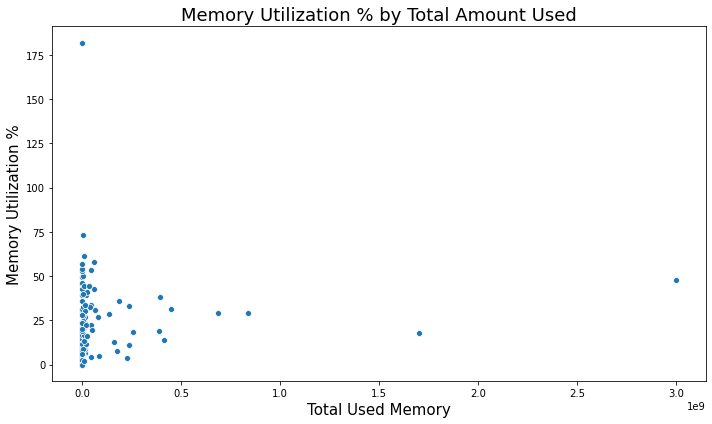

In [34]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='USEDMEM_TOT_02', y='USEDMEM_PCT_02', data=accre_grouped_by_account)
# set labels
plt.xlabel('Total Used Memory', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization % by Total Amount Used', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


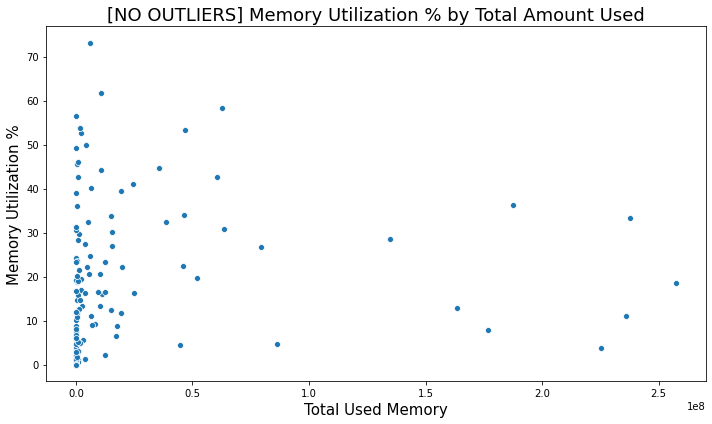

In [35]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='USEDMEM_TOT_02', y='USEDMEM_PCT_02', data=accre_grouped_by_account[(accre_grouped_by_account['USEDMEM_TOT_02'] < 300000000) & (accre_grouped_by_account['USEDMEM_PCT_02'] < 100)])
# set labels
plt.xlabel('Total Used Memory', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('[NO OUTLIERS] Memory Utilization % by Total Amount Used', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)

In [36]:
# Take a look at the outliers in terms of the total memory used
accre_grouped_by_account[accre_grouped_by_account['USEDMEM_TOT_02'] >= 300000000]

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF
20,bulk,4.146121e+08,2.916727e+09,78516,1.198295e+10,2.483894e+08,78516,14.214975,1.000000,0.000000
26,carrot,4.513014e+08,1.445000e+09,192470,2.076144e+10,4.066022e+09,192682,31.231925,1.001101,0.029695
29,cep,8.364966e+08,2.855096e+09,608551,5.766025e+10,1.034218e+10,608651,29.298368,1.000164,0.000244
36,cms,1.699620e+09,9.410254e+09,488997,8.287823e+10,1.098006e+10,488997,18.061362,1.000000,0.000000
37,cms_lowprio,3.867233e+08,2.025781e+09,135189,2.333863e+10,3.135662e+09,135193,19.090088,1.000030,0.000000
55,galia,6.871519e+08,2.375425e+09,197698,1.917386e+10,1.944477e+09,197698,28.927533,1.000000,0.000000
106,retailer,3.923267e+08,1.024663e+09,38994,2.242337e+09,3.695265e+08,39482,38.288364,1.012515,0.362844
122,summer,2.998449e+09,6.235026e+09,380486,3.580462e+09,9.877357e+08,380559,48.090396,1.000192,0.018387


Note that the 'summer' group is an outlier in terms of their total memory used and the 'crowns' group is an outlier in terms of their memory utilization rate.

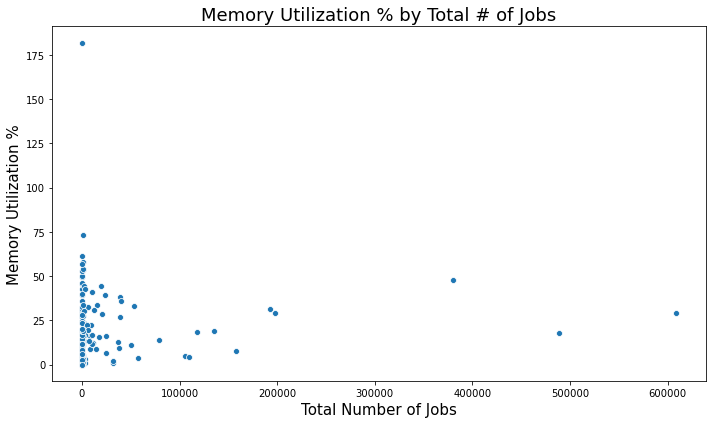

In [37]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='JOBID', y='USEDMEM_PCT_02', data=accre_grouped_by_account)
# set labels
plt.xlabel('Total Number of Jobs', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization % by Total # of Jobs', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


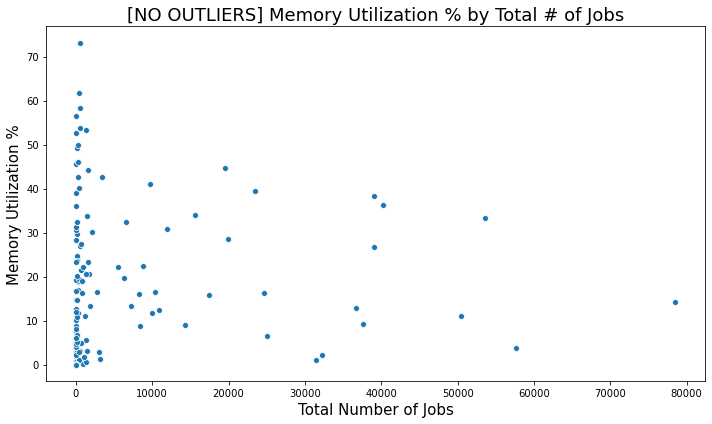

In [38]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='JOBID', y='USEDMEM_PCT_02', data=accre_grouped_by_account[(accre_grouped_by_account['JOBID'] <= 100000) & (accre_grouped_by_account['USEDMEM_PCT_02'] < 100)])
# set labels
plt.xlabel('Total Number of Jobs', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('[NO OUTLIERS] Memory Utilization % by Total # of Jobs', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


In [39]:
# Take a look at the outliers in terms of number of jobs run
accre_grouped_by_account[accre_grouped_by_account['JOBID'] >= 100000]

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF
21,bunch,8.615580e+07,1.801075e+09,105865,2.609234e+10,3.204947e+08,105865,4.783577,1.000000,0.000000
26,carrot,4.513014e+08,1.445000e+09,192470,2.076144e+10,4.066022e+09,192682,31.231925,1.001101,0.029695
27,casaba,2.572572e+08,1.385027e+09,117690,2.821190e+09,7.710151e+08,117724,18.574169,1.000289,0.000732
29,cep,8.364966e+08,2.855096e+09,608551,5.766025e+10,1.034218e+10,608651,29.298368,1.000164,0.000244
36,cms,1.699620e+09,9.410254e+09,488997,8.287823e+10,1.098006e+10,488997,18.061362,1.000000,0.000000
37,cms_lowprio,3.867233e+08,2.025781e+09,135189,2.333863e+10,3.135662e+09,135193,19.090088,1.000030,0.000000
55,galia,6.871519e+08,2.375425e+09,197698,1.917386e+10,1.944477e+09,197698,28.927533,1.000000,0.000000
88,orange,1.769680e+08,2.255491e+09,158208,6.784493e+09,2.159593e+08,158208,7.846096,1.000000,0.000000
102,portabella,4.483182e+07,1.026304e+09,109595,9.361374e+09,1.706923e+09,109595,4.368279,1.000000,0.000000
122,summer,2.998449e+09,6.235026e+09,380486,3.580462e+09,9.877357e+08,380559,48.090396,1.000192,0.018387


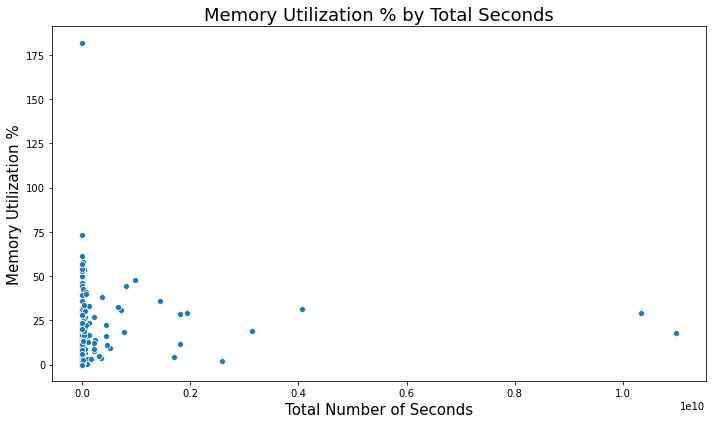

In [40]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='USEDTIME_SEC', y='USEDMEM_PCT_02', data=accre_grouped_by_account)
# set labels
plt.xlabel('Total Number of Seconds', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization % by Total Seconds', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


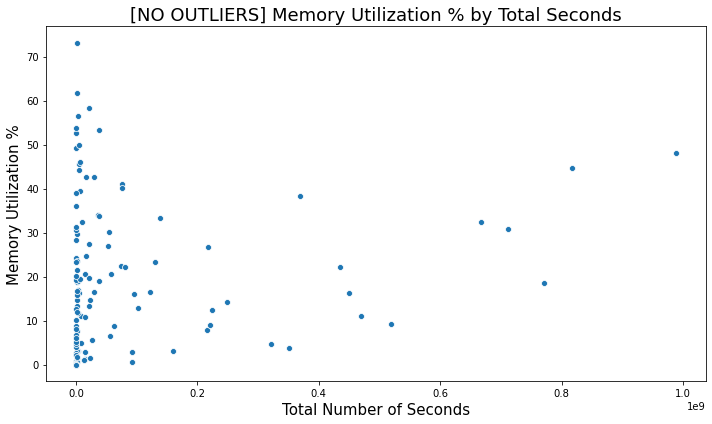

In [41]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='USEDTIME_SEC', y='USEDMEM_PCT_02', data=accre_grouped_by_account[(accre_grouped_by_account['USEDTIME_SEC'] <= 1400000000) & (accre_grouped_by_account['USEDMEM_PCT_02'] < 100)])
# set labels
plt.xlabel('Total Number of Seconds', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('[NO OUTLIERS] Memory Utilization % by Total Seconds', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


In [42]:
# Take a look at the outliers in terms of number of seconds used
accre_grouped_by_account[accre_grouped_by_account['USEDTIME_SEC'] > 1400000000]

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF
26,carrot,4.513014e+08,1.445000e+09,192470,2.076144e+10,4.066022e+09,192682,31.231925,1.001101,0.029695
29,cep,8.364966e+08,2.855096e+09,608551,5.766025e+10,1.034218e+10,608651,29.298368,1.000164,0.000244
36,cms,1.699620e+09,9.410254e+09,488997,8.287823e+10,1.098006e+10,488997,18.061362,1.000000,0.000000
37,cms_lowprio,3.867233e+08,2.025781e+09,135189,2.333863e+10,3.135662e+09,135193,19.090088,1.000030,0.000000
55,galia,6.871519e+08,2.375425e+09,197698,1.917386e+10,1.944477e+09,197698,28.927533,1.000000,0.000000
56,garlic,1.349305e+08,4.713296e+08,19968,6.560476e+09,1.811219e+09,19968,28.627636,1.000000,0.000000
102,portabella,4.483182e+07,1.026304e+09,109595,9.361374e+09,1.706923e+09,109595,4.368279,1.000000,0.000000
105,regal,1.923572e+07,1.639793e+08,9973,4.014320e+09,1.820619e+09,9973,11.730581,1.000000,0.000000
125,sweet,1.873398e+08,5.171192e+08,40237,5.112297e+09,1.442212e+09,40237,36.227584,1.000000,0.000000
137,wood,1.250538e+07,5.682796e+08,32243,8.704380e+09,2.586676e+09,34437,2.200569,1.068046,0.047938


##### Now that the numbers are aggregated at the account level, create two sorted dataframes, sorted by TOTAL used memory and used memory RATE.

In [43]:
# Sort groups by total memory used, memory usage rates, and number of jobs
accre_grouped_by_account_sorted_by_usedmem_tot = accre_grouped_by_account.sort_values(by=['USEDMEM_TOT_02', 'USEDMEM_PCT_02', 'JOBID'], ascending = True)
# Sort groups by memory usage rates and number of jobs
accre_grouped_by_account_sorted_by_usedmem_rate = accre_grouped_by_account.sort_values(by=['USEDMEM_PCT_02', 'JOBID'], ascending = True)

In [44]:
# Check out the two dataframes
print(accre_grouped_by_account_sorted_by_usedmem_tot.head())
print(accre_grouped_by_account_sorted_by_usedmem_rate.head())

       ACCOUNT  USEDMEM_TOT_02  REQMEM_TOT  JOBID  REQTIME_SEC  USEDTIME_SEC  NODES  USEDMEM_PCT_02  NODES_PER_JOB  USEDMEM_DIFF
46   discovery             0.0      2048.0      1       1200.0           8.0      1             0.0            1.0           0.0
50    flamingo             0.0      2048.0      1       1200.0          11.0      1             0.0            1.0           0.0
59        hass             0.0      2048.0      1       1200.0          49.0      1             0.0            1.0           0.0
103  president             0.0      2048.0      1       1200.0          11.0      1             0.0            1.0           0.0
136       with             0.0      2048.0      1       1200.0           8.0      1             0.0            1.0           0.0
       ACCOUNT  USEDMEM_TOT_02  REQMEM_TOT  JOBID  REQTIME_SEC  USEDTIME_SEC  NODES  USEDMEM_PCT_02  NODES_PER_JOB  USEDMEM_DIFF
46   discovery             0.0      2048.0      1       1200.0           8.0      1             0

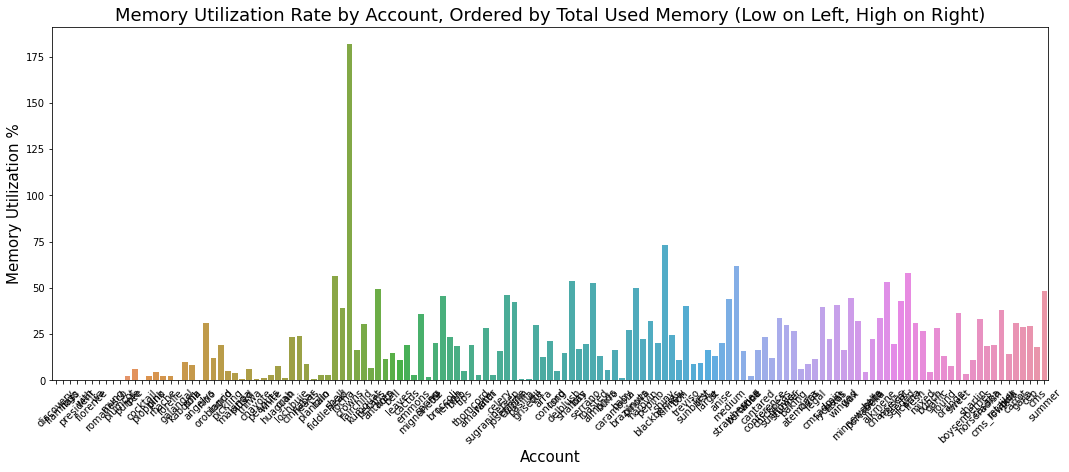

In [45]:
# Plot the used memory rate by account, ordered by total used memory
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_grouped_by_account_sorted_by_usedmem_tot)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization Rate by Account, Ordered by Total Used Memory (Low on Left, High on Right)', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


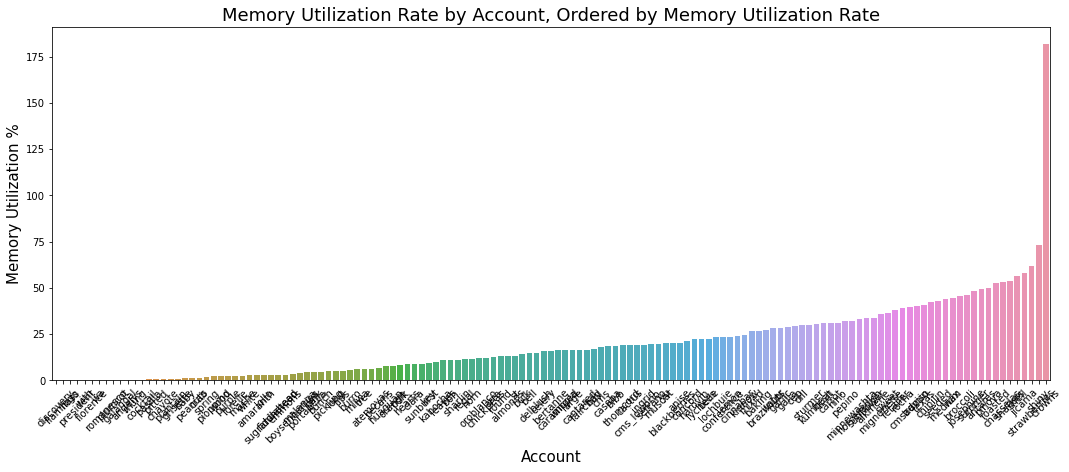

In [46]:
# Plot the used memory rate by account, ordered by rate
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_grouped_by_account_sorted_by_usedmem_rate)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization Rate by Account, Ordered by Memory Utilization Rate', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


The AVERAGE memory utilization % is 19 and the MEDIAN is 14.4%.

In [47]:
# Generate quartiles based on memory usage
# accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'] = pd.qcut(accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_PCT_02'], q=4)

In [48]:
# Create quartiles by memory usage rate
bin_labels_4 = ['1', '2', '3', '4']
accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'] = pd.qcut(accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_PCT_02'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels_4)
accre_grouped_by_account_sorted_by_usedmem_rate.head()

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF,USEDMEM_QRTL
46,discovery,0.0,2048.0,1,1200.0,8.0,1,0.0,1.0,0.0,1
50,flamingo,0.0,2048.0,1,1200.0,11.0,1,0.0,1.0,0.0,1
59,hass,0.0,2048.0,1,1200.0,49.0,1,0.0,1.0,0.0,1
103,president,0.0,2048.0,1,1200.0,11.0,1,0.0,1.0,0.0,1
136,with,0.0,2048.0,1,1200.0,8.0,1,0.0,1.0,0.0,1


In [49]:
# Create quartiles by total memory used
bin_labels_4 = ['1', '2', '3', '4']
accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_QRTL'] = pd.qcut(accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_TOT_02'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels_4)
accre_grouped_by_account_sorted_by_usedmem_tot.head()

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF,USEDMEM_QRTL
46,discovery,0.0,2048.0,1,1200.0,8.0,1,0.0,1.0,0.0,1
50,flamingo,0.0,2048.0,1,1200.0,11.0,1,0.0,1.0,0.0,1
59,hass,0.0,2048.0,1,1200.0,49.0,1,0.0,1.0,0.0,1
103,president,0.0,2048.0,1,1200.0,11.0,1,0.0,1.0,0.0,1
136,with,0.0,2048.0,1,1200.0,8.0,1,0.0,1.0,0.0,1


In [50]:
# Turn the quartile into a number
accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'] = pd.to_numeric(accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'])
accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_QRTL'] = pd.to_numeric(accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_QRTL'])

In [51]:
# Make sure the quartile is a number
print(accre_grouped_by_account_sorted_by_usedmem_rate.info())
print(accre_grouped_by_account_sorted_by_usedmem_tot.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 46 to 43
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ACCOUNT         139 non-null    object 
 1   USEDMEM_TOT_02  139 non-null    float64
 2   REQMEM_TOT      139 non-null    float64
 3   JOBID           139 non-null    int64  
 4   REQTIME_SEC     139 non-null    float64
 5   USEDTIME_SEC    139 non-null    float64
 6   NODES           139 non-null    int64  
 7   USEDMEM_PCT_02  139 non-null    float64
 8   NODES_PER_JOB   139 non-null    float64
 9   USEDMEM_DIFF    139 non-null    float64
 10  USEDMEM_QRTL    139 non-null    int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 18.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 46 to 122
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ACCOUNT         139 non-null    object 
 

In [52]:
# Check how many are in each quartile
print(accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'].value_counts())
print(accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_QRTL'].value_counts())

4    35
2    35
1    35
3    34
Name: USEDMEM_QRTL, dtype: int64
4    35
2    35
1    35
3    34
Name: USEDMEM_QRTL, dtype: int64


In [53]:
# Create top and bottom quartile datasets, based on usedmem total and usedmem rate, to improve legibility below
accre_top_25_pct_usedmem_rate = accre_grouped_by_account_sorted_by_usedmem_rate[accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'] == 4]
accre_bottom_25_pct_usedmem_rate = accre_grouped_by_account_sorted_by_usedmem_rate[accre_grouped_by_account_sorted_by_usedmem_rate['USEDMEM_QRTL'] == 1]
accre_top_25_pct_usedmem_tot = accre_grouped_by_account_sorted_by_usedmem_tot[accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_QRTL'] == 4]
accre_bottom_25_pct_usedmem_tot = accre_grouped_by_account_sorted_by_usedmem_tot[accre_grouped_by_account_sorted_by_usedmem_tot['USEDMEM_QRTL'] == 1]

In [74]:
accre_top_25_pct_usedmem_tot.describe()

,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF,USEDMEM_QRTL
count,3.500000e+01,3.500000e+01,35.00000,3.500000e+01,3.500000e+01,35.000000,35.000000,35.000000,35.000000,35.0
mean,2.940056e+08,1.386033e+09,88300.80000,9.382647e+09,1.283682e+09,88435.114286,25.712647,1.005184,0.213595,4.0
std,5.710581e+08,2.066164e+09,139553.44501,1.696767e+10,2.520240e+09,139521.590179,14.637433,0.018916,0.739975,0.0
min,1.713274e+07,4.936499e+07,519.00000,7.720452e+07,6.652403e+06,519.000000,3.730489,1.000000,0.000000,4.0
25%,4.175290e+07,1.473951e+08,9868.00000,1.067295e+09,7.432864e+07,9868.000000,13.586746,1.000000,0.000000,4.0
50%,7.930348e+07,4.713296e+08,36698.00000,3.580462e+09,3.695265e+08,36701.000000,26.791484,1.000000,0.000000,4.0
75%,2.474627e+08,1.913428e+09,107730.00000,9.502102e+09,1.214974e+09,107730.000000,35.108043,1.000264,0.004351,4.0
max,2.998449e+09,9.410254e+09,608551.00000,8.287823e+10,1.098006e+10,608651.000000,58.250854,1.103818,3.291517,4.0


In [77]:
accre_top_25_pct_usedmem_tot

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF,USEDMEM_QRTL
7,atemoyas,1.713274e+07,2.668677e+08,25012,1.636805e+09,5.542806e+07,25012,6.419936,1.000000,0.000000,4
35,clara,1.751899e+07,1.974436e+08,8386,4.474944e+08,6.214876e+07,8388,8.872908,1.000238,0.000131,4
105,regal,1.923572e+07,1.639793e+08,9973,4.014320e+09,1.820619e+09,9973,11.730581,1.000000,0.000000,4
38,cmsadmin,1.947637e+07,4.936499e+07,23437,1.012478e+09,6.652403e+06,23437,39.453806,1.000000,0.000000,4
77,lychees,1.963169e+07,8.825722e+07,5505,1.036053e+09,4.347623e+08,5505,22.243724,1.000000,0.000000,4
126,texas,2.457601e+07,5.986378e+07,9763,3.428582e+08,7.511876e+07,9763,41.053225,1.000000,0.000000,4
135,winged,2.493229e+07,1.533568e+08,24620,9.642830e+09,4.498099e+08,27176,16.257704,1.103818,3.006474,4
133,wax,3.577738e+07,8.022016e+07,19585,2.256192e+09,8.172275e+08,19585,44.598984,1.000000,0.000000,4
83,minnewashta,3.867398e+07,1.193324e+08,6571,2.755192e+09,6.679822e+08,6571,32.408608,1.000000,0.000000,4
102,portabella,4.483182e+07,1.026304e+09,109595,9.361374e+09,1.706923e+09,109595,4.368279,1.000000,0.000000,4


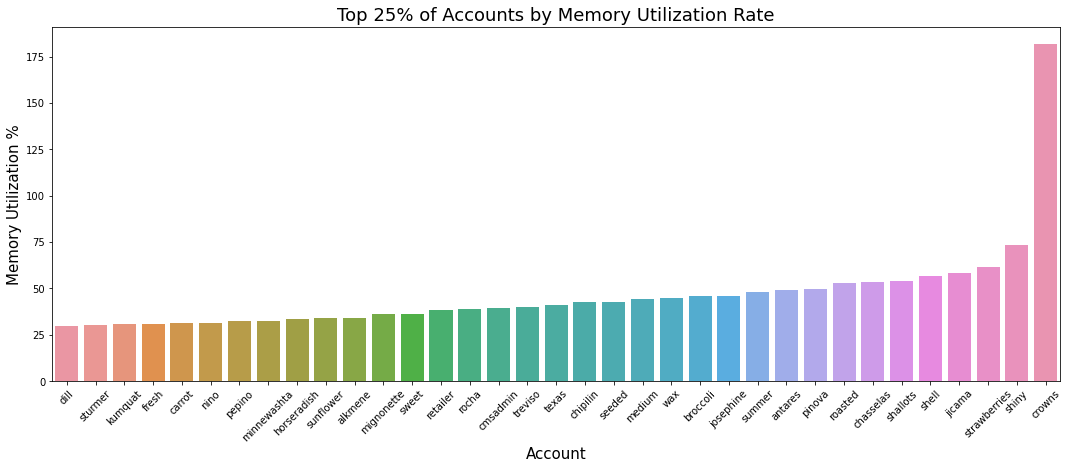

In [54]:
# Plot the top performers based on memory utilization rate
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_top_25_pct_usedmem_rate)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Top 25% of Accounts by Memory Utilization Rate', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


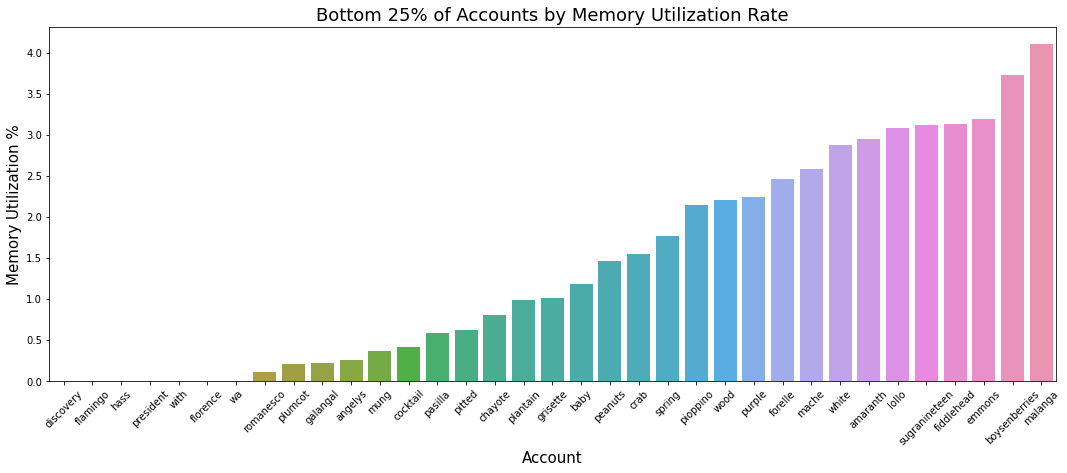

In [55]:
# Plot the top performers based on memory utilization rate
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_bottom_25_pct_usedmem_rate)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Bottom 25% of Accounts by Memory Utilization Rate', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


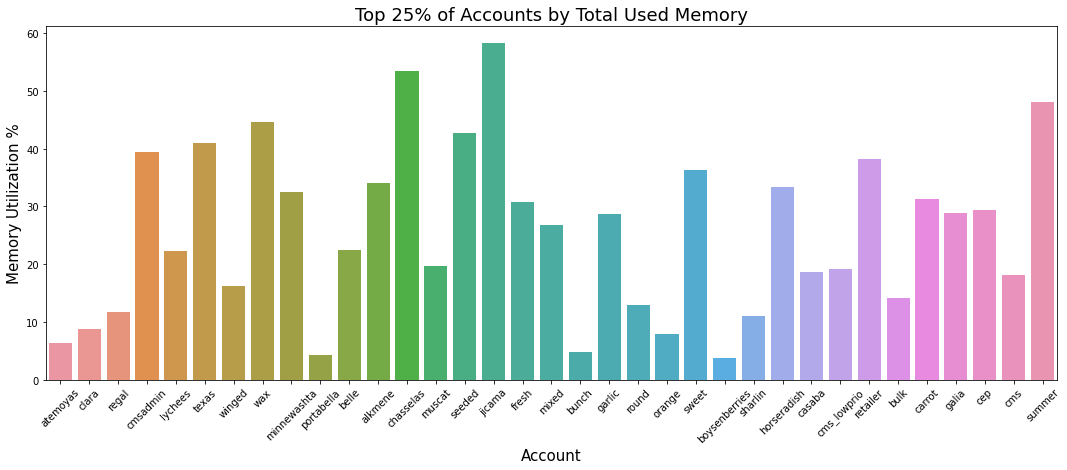

In [56]:
# Plot the top performers based on memory utilization rate
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_top_25_pct_usedmem_tot)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Top 25% of Accounts by Total Used Memory', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


In [57]:
# Sort the top quartile of users (based on total memory use) by their memory utilization rates
accre_top_25_pct_usedmem_tot_sorted = accre_top_25_pct_usedmem_tot.sort_values(by='USEDMEM_PCT_02')

In [78]:
accre_top_25_pct_usedmem_tot_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 17 to 65
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ACCOUNT         35 non-null     object 
 1   USEDMEM_TOT_02  35 non-null     float64
 2   REQMEM_TOT      35 non-null     float64
 3   JOBID           35 non-null     int64  
 4   REQTIME_SEC     35 non-null     float64
 5   USEDTIME_SEC    35 non-null     float64
 6   NODES           35 non-null     int64  
 7   USEDMEM_PCT_02  35 non-null     float64
 8   NODES_PER_JOB   35 non-null     float64
 9   USEDMEM_DIFF    35 non-null     float64
 10  USEDMEM_QRTL    35 non-null     int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 4.5+ KB


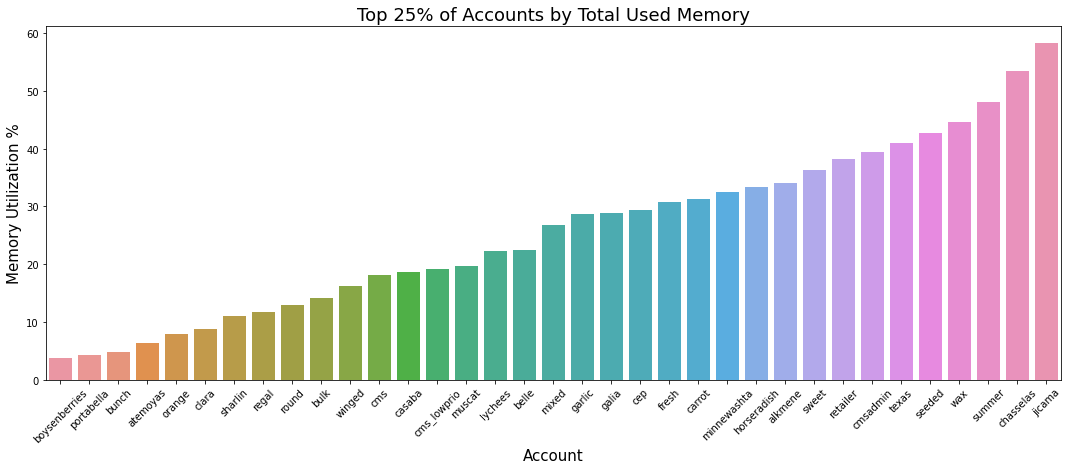

In [58]:
# Plot the top performers based on memory utilization rate - i.e. reorder the graph above
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_top_25_pct_usedmem_tot_sorted)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Top 25% of Accounts by Total Used Memory', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)

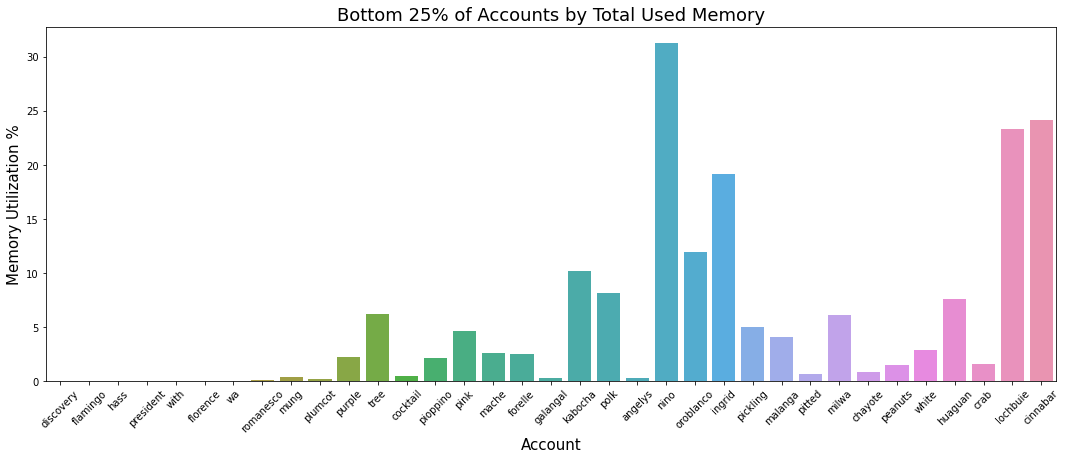

In [59]:
# Plot the top performers based on memory utilization rate
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_bottom_25_pct_usedmem_tot)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Bottom 25% of Accounts by Total Used Memory', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


To set limits:
* The AVERAGE memory used rate is used as a cutoff to enlarge the opportunity base
* The MEDIAN total memory used is used as a cutoff to account for the one outlier in total memory usage who is skewing the entire dataset

In [60]:
# define variables for average and median of total used memory and used memory rate
accre_usedmem_tot_avg = 75971100
accre_usedmem_tot_med = 1464956

accre_usedmem_rate_avg = 19.769203
accre_usedmem_rate_med = 15.97974

In [61]:
# Get the low-performing, high-usage users based on ACCRE AVERAGE memory utilization
accre_mem_top_opportunity = accre_top_25_pct_usedmem_tot_sorted[accre_top_25_pct_usedmem_tot_sorted['USEDMEM_PCT_02'] <= accre_usedmem_rate_avg].sort_values(by='USEDMEM_TOT_02')
accre_mem_top_opportunity

,ACCOUNT,USEDMEM_TOT_02,REQMEM_TOT,JOBID,REQTIME_SEC,USEDTIME_SEC,NODES,USEDMEM_PCT_02,NODES_PER_JOB,USEDMEM_DIFF,USEDMEM_QRTL
7,atemoyas,1.713274e+07,2.668677e+08,25012,1.636805e+09,5.542806e+07,25012,6.419936,1.000000,0.000000,4
35,clara,1.751899e+07,1.974436e+08,8386,4.474944e+08,6.214876e+07,8388,8.872908,1.000238,0.000131,4
105,regal,1.923572e+07,1.639793e+08,9973,4.014320e+09,1.820619e+09,9973,11.730581,1.000000,0.000000,4
135,winged,2.493229e+07,1.533568e+08,24620,9.642830e+09,4.498099e+08,27176,16.257704,1.103818,3.006474,4
102,portabella,4.483182e+07,1.026304e+09,109595,9.361374e+09,1.706923e+09,109595,4.368279,1.000000,0.000000,4
86,muscat,5.177709e+07,2.630870e+08,6282,1.098536e+09,2.151372e+07,6282,19.680593,1.000000,0.000000,4
21,bunch,8.615580e+07,1.801075e+09,105865,2.609234e+10,3.204947e+08,105865,4.783577,1.000000,0.000000,4
110,round,1.634521e+08,1.261349e+09,36698,3.870887e+09,1.024826e+08,36701,12.958517,1.000082,0.006239,4
88,orange,1.769680e+08,2.255491e+09,158208,6.784493e+09,2.159593e+08,158208,7.846096,1.000000,0.000000,4
17,boysenberries,2.253211e+08,6.039990e+09,57597,4.122432e+09,3.509877e+08,57636,3.730489,1.000677,0.000010,4


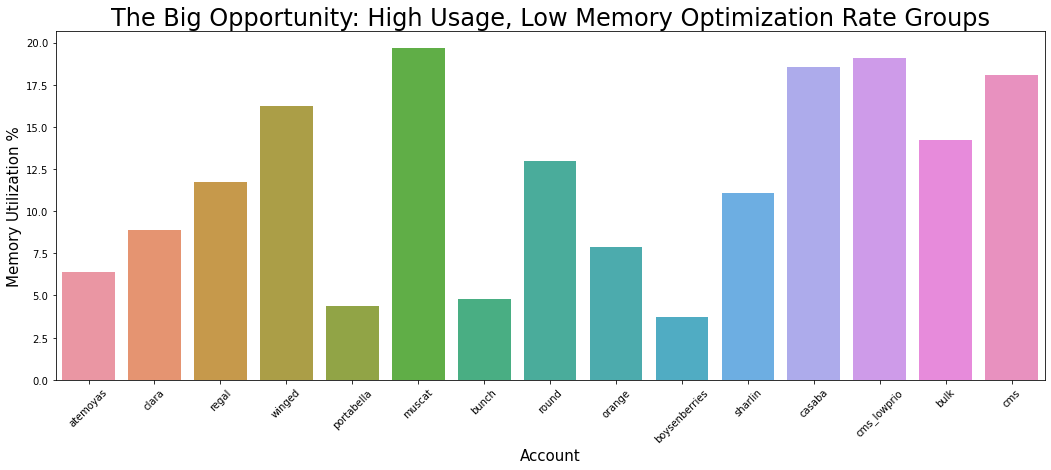

In [62]:
# Plot the users who use the most and are the least optimized
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_mem_top_opportunity)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('The Big Opportunity: High Usage, Low Memory Optimization Rate Groups', size=24)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('low-performers-bar.png', dpi=300)
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)

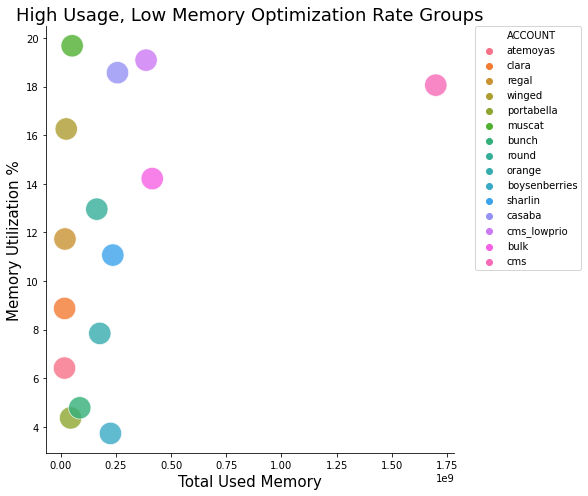

In [64]:
#plt.figure(figsize=(100,100))
ax = sns.relplot(x='USEDMEM_TOT_02', # Horizontal axis
           y='USEDMEM_PCT_02', # Vertical axis
           data=accre_mem_top_opportunity, # Data source
           hue = 'ACCOUNT', height = 7, aspect = 1,
           s=500, alpha = 0.8) # size and dimension

plt.title('High Usage, Low Memory Optimization Rate Groups', size=18)
# Set x-axis label
plt.xlabel('Total Used Memory', size=15)
# Set y-axis label
plt.ylabel('Memory Utilization %', size=15)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax._legend.remove()
plt.subplots_adjust(right=0.75)
# figure = ax.get_figure()    
# figure.savefig('high-performers.png', dpi=300)
plt.savefig('low-performers-scatter.png', dpi=300)

#def label_point(x, y, val, ax):
#    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#    for i, point in a.iterrows():
#        ax.text(point['x']+0.5, point['y'], str(point['val']))

#label_point(accre_mem_model_users.USEDMEM_TOT_02, accre_mem_model_users.USEDMEM_PCT_02, accre_mem_model_users.ACCOUNT, plt.gca()) 

The Big Opportunity: Improving these 13 users' memory utilization rates should have the highest impact on overall memory utilization rates.

In [ ]:
accre_mem_opportunity = accre_grouped_by_account[(accre_grouped_by_account['USEDMEM_PCT_02'] <= accre_usedmem_rate_avg) & (accre_grouped_by_account['USEDMEM_TOT_02'] >= accre_usedmem_tot_med)].sort_values(by='USEDMEM_TOT_02')
accre_mem_opportunity

In [ ]:
# Plot the top performers based on memory utilization rate - i.e. reorder the graph above
plt.figure(figsize=(15,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_mem_opportunity)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('More Opportunities to Optimize, ordered by Total Used Mem', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)

The 31 users here use above the median amount of memory but have below-average memory usage rates. I chose the median amount of memory since the average is drawn up due to a small handful of outliers.

In [ ]:
# Get the high-performing, high-usage users based on ACCRE AVERAGE memory utilization
# accre_mem_model_users = accre_top_25_pct_usedmem_rate[accre_top_25_pct_usedmem_rate['USEDMEM_TOT_02'] >= accre_usedmem_tot_avg].sort_values(by='USEDMEM_TOT_02')
accre_mem_model_users = accre_top_25_pct_usedmem_rate[accre_top_25_pct_usedmem_rate['USEDMEM_TOT_02'] >= accre_usedmem_tot_avg].sort_values(by='USEDMEM_TOT_02')

accre_mem_model_users

The Model: These 24 users are in the top 25% of ACCRE users based on their memory utilization rates AND they consume above the median amount of memory. (The median was chosen due to the fact that the average total memory used is drawn up by a small number of outliers.)

In [ ]:
# Plot the top performers based on memory utilization rate - i.e. reorder the graph above
plt.figure(figsize=(15,6))
# make barplot
g = sns.barplot(x='ACCOUNT', y='USEDMEM_PCT_02', data=accre_mem_model_users)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('High Usage, High Memory Optimization Rate Groups', size=24)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('high-performers-bar.png', dpi=300)

# plt.savefig("barplot_Seaborn_Python.png", dpi=100)

In [ ]:
#plt.figure(figsize=(100,100))
ax = sns.relplot(x='USEDMEM_TOT_02', # Horizontal axis
           y='USEDMEM_PCT_02', # Vertical axis
           data=accre_mem_model_users, # Data source
           hue = 'ACCOUNT', height = 7, aspect = 1,
           s=500, alpha = 0.8, ax=ax) # size and dimension

plt.title('High Usage, High Memory Optimization Rate Groups', size=18)
# Set x-axis label
plt.xlabel('Total Used Memory', size=15)
# Set y-axis label
plt.ylabel('Memory Utilization %', size=15)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax._legend.remove()
plt.subplots_adjust(right=0.75)
# figure = ax.get_figure()    
# figure.savefig('high-performers.png', dpi=300)
plt.savefig('high-performers-scatter.png', dpi=300)

#def label_point(x, y, val, ax):
#    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#    for i, point in a.iterrows():
#        ax.text(point['x']+0.5, point['y'], str(point['val']))

#label_point(accre_mem_model_users.USEDMEM_TOT_02, accre_mem_model_users.USEDMEM_PCT_02, accre_mem_model_users.ACCOUNT, plt.gca()) 

In [ ]:
# WIP: IS IT POSSIBLE TO CALCULATE AN OPTIMIZATION SCORE?
accre_grouped_by_account['MEM_OPT_SCORE'] = accre_grouped_by_account['USEDMEM_TOT_02'] / accre_grouped_by_account['USEDMEM_PCT_02']
accre_grouped_by_account.sort_values('MEM_OPT_SCORE', ascending = False)

In [ ]:
underperforming_accounts = accre_mem_top_opportunity['ACCOUNT'].to_list()

In [ ]:
underperforming_accounts

In [ ]:
# Take a look at the users within the underperforming accounts
accre_underperformers = accre_mem_use[accre_mem_use['ACCOUNT'].isin(underperforming_accounts)]
accre_underperformers.head(200)

In [ ]:
accre_grouped_by_user = accre_underperformers.groupby(['ACCOUNT', 'USER']).agg(
    {   'USEDMEM_TOT_02': 'sum',
        'REQMEM_TOT': 'sum',
        'JOBID': 'count',
        'REQTIME_SEC': 'sum',
        'USEDTIME_SEC': 'sum',
         'NODES' : 'sum'
    }
)

In [ ]:
accre_grouped_by_user['USEDMEM_PCT_02'] = (accre_grouped_by_user['USEDMEM_TOT_02'] / accre_grouped_by_user['REQMEM_TOT'])*100

In [ ]:
# Create user quartiles by memory usage rate
bin_labels_4 = ['1', '2', '3', '4']
accre_grouped_by_user['USEDMEM_PCT_QRTL'] = pd.qcut(accre_grouped_by_user['USEDMEM_PCT_02'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels_4)
accre_grouped_by_user['USEDMEM_TOT_QRTL'] = pd.qcut(accre_grouped_by_user['USEDMEM_TOT_02'],
                              q=[0, .25, .5, .75, 1],
                              labels=bin_labels_4)
accre_grouped_by_user.head()

In [ ]:
accre_grouped_by_user['USEDMEM_PCT_QRTL'] = pd.to_numeric(accre_grouped_by_user['USEDMEM_PCT_QRTL'])
accre_grouped_by_user['USEDMEM_TOT_QRTL'] = pd.to_numeric(accre_grouped_by_user['USEDMEM_TOT_QRTL'])
accre_grouped_by_user = accre_grouped_by_user.reset_index()

In [ ]:
accre_low_performing_high_impact_users = accre_grouped_by_user[(accre_grouped_by_user['USEDMEM_PCT_QRTL'] == 1) & (accre_grouped_by_user['USEDMEM_TOT_QRTL'] == 4)]
users_of_interest = accre_low_performing_high_impact_users['USER'].to_list()

In [ ]:
accre_grouped_by_user_sorted_by_usedmem_tot = accre_grouped_by_user.sort_values(by='USEDMEM_TOT_02')

In [ ]:
accre_grouped_by_user_sorted_by_usedmem_tot

In [ ]:
users_of_interest

In [ ]:
users_of_interest_jobs = accre_mem_use[accre_mem_use['USER'].isin(users_of_interest)]

In [ ]:
# Take a look to see if there's a correlation between USEDMEM_PCT and USEDMEM_TOT
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='USEDTIME_SEC', y='USEDMEM_PCT_JOB_02', hue = 'USER', data=users_of_interest_jobs)
# set labels
plt.xlabel('Total Used Time', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title("Bottom Performers' Jobs", size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)
